This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Fundamentals of machine learning

## Generalization: the goal of machine learning

The fundamental issue in machine learning is the tension between optimization and generalization. **Optimization** refers to the process of adjusting a model to get the best performance possible on the training data (the learning in machine learning), whereas **generalization** refers to how well the trained model performs on data it has never seen before. The goal of the game is to get good generalization, of course, but you don’t control generalization; you can only fit the model to its training data. If you do that too well, overfitting kicks in and generalization suffers.

### Underfitting and overfitting

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/typical_overfitting.png)

At the beginning of training, optimization and generalization are **correlated**: the lower the loss on training data, the lower the loss on test data. While this is happening, your model is said to be **underfit**: there is still progress to be made; the network hasn’t yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, **generalization stops improving**, validation metrics stall and then begin to degrade: the model is starting to **overfit**. That is, it’s beginning to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.

Overfitting is particularly likely to occur when your **data is noisy, if it involves uncertainty, or if it includes rare features. Let’s look at concrete examples**.

#### Noisy training data

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/fucked_up_mnist.png)

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/mislabeled_mnist.png)

If a model goes out of its way to incorporate such **outliers**, its generalization performance will degrade. For instance, a 4 that looks very close to the mislabeled 4 above may end up getting classified as a 9.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/outliers_and_overfitting.png)

#### Ambiguous features

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/overfitting_with_uncertainty.png)

#### Rare features and spurious correlations

Likewise, machine learning models trained on datasets that include **rare feature values are highly susceptible to overfitting**. In a sentiment classification task, if the word "cherimoya" (a fruit native to the Andes) only appears in one text in the training data, and this text happens to be negative in sentiment, a poorly-regularized model might put a very high weight on this word and always classify new texts that mention cherimoyas as negative. Whereas, objectively, there’s nothing negative about the cherimoya. [9]

**Adding white-noise channels or all-zeros channels to MNIST**

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

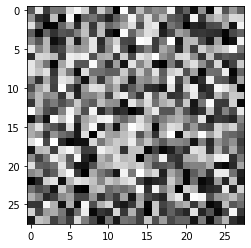

In [12]:
import matplotlib.pyplot as plt

plt.figure()

plt.imshow(np.random.random((1, 784)).reshape(28,28), cmap="binary")

**Training the same model on MNIST data with noise channels or all-zero channels**

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 6ms/step - loss: 0.6204 - accuracy: 0.8120 - val_loss: 0.2579 - val_accuracy: 0.9208
Epoch 2/10
375/375 [==============================] - 2s 5ms/step - loss: 0.2526 - accuracy: 0.9216 - val_loss: 0.2172 - val_accuracy: 0.9317
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.1646 - accuracy: 0.9493 - val_loss: 0.1725 - val_accuracy: 0.9488
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.1159 - accuracy: 0.9639 - val_loss: 0.1329 - val_accuracy: 0.9630
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0849 - accuracy: 0.9735 - val_loss: 0.1384 - val_accuracy: 0.9590
Epoch 6/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0649 - accuracy: 0.9799 - val_loss: 0.1210 - val_accuracy: 0.9653
Epoch 7/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0469 - accuracy: 0.9850 - val_loss: 0.1181 - val_accuracy: 0.9670
Epoch 

**Plotting a validation accuracy comparison**

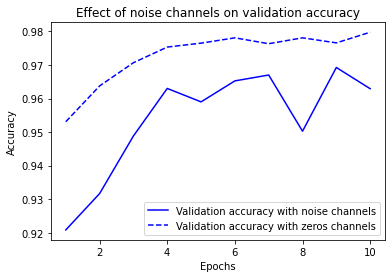

In [17]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]

epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")

plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Despite the data holding the same information in both cases, the validation accuracy of the model trained with noise channels ends up about one percentage point lower—purely through the **influence of spurious correlations**. The more noise channels you would add, the further accuracy would degrade.

### The nature of generalization in deep learning

A remarkable fact about deep learning models is that they can be **trained to fit anything**, as long as they have enough representational power.

**Fitting a MNIST model with randomly shuffled labels**

Don’t believe me? Try shuffling the MNIST labels and train a model on that. Even though there is no relationship whatsoever between the inputs and the shuffled labels, the **training loss goes down just fine**, even with a relatively small model. Naturally, the validation loss does not improve at all over time, since there is no possibility of generalization in this setting.

In [25]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 2s 3ms/step - loss: 2.3188 - accuracy: 0.1043 - val_loss: 2.3100 - val_accuracy: 0.1023
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3003 - accuracy: 0.1153 - val_loss: 2.3158 - val_accuracy: 0.1044
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2897 - accuracy: 0.1285 - val_loss: 2.3208 - val_accuracy: 0.1011
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2769 - accuracy: 0.1409 - val_loss: 2.3241 - val_accuracy: 0.1019
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2601 - accuracy: 0.1558 - val_loss: 2.3320 - val_accuracy: 0.0978
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2381 - accuracy: 0.1684 - val_loss: 2.3513 - val_accuracy: 0.1018
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2144 - accuracy: 0.1850 - val_loss: 2.3645 - val_accuracy: 0.1035

Epoch 58/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9377 - accuracy: 0.6886 - val_loss: 4.6931 - val_accuracy: 0.1008
Epoch 59/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9225 - accuracy: 0.6938 - val_loss: 4.7061 - val_accuracy: 0.1006
Epoch 60/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9096 - accuracy: 0.6992 - val_loss: 4.7591 - val_accuracy: 0.1051
Epoch 61/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8955 - accuracy: 0.7045 - val_loss: 4.8084 - val_accuracy: 0.0991
Epoch 62/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8815 - accuracy: 0.7079 - val_loss: 4.8561 - val_accuracy: 0.1032
Epoch 63/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8688 - accuracy: 0.7131 - val_loss: 4.9335 - val_accuracy: 0.1000
Epoch 64/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8551 - accuracy: 0.7171 - val_loss: 5.0540 - val_accuracy:

In fact, you don’t even need to do this with MNIST data—you could just **generate white-noise inputs and random labels. You could fit a model on that, too**, as long as it has enough parameters. It would just end up memorizing specific inputs, much like a Python dictionary.

#### The manifold hypothesis

The input to a MNIST classifier (before preprocessing) is a $28 \times 28$ array of integers between $0$ and $255$. The total number of possible input values is thus $256$ to the power of $784$—much greater than the number of atoms in the universe. However, very few of these inputs would look like valid MNIST samples: actual handwritten digits only occupy a **tiny subspace of the parent space** of all possible $28 \times 28$ `uint8` arrays. What’s more, this subspace isn’t just a set of points sprinkled at random in the parent space: it is **highly structured**.

First, the subspace of valid handwritten digits is **continuous**: if you take a sample and modify it a little, it will still be recognizable as the same handwritten digit. Further, all samples in the valid subspace are **connected by smooth paths** that run through the subspace. This means that if you take two random MNIST digits A and B, there exists a sequence of "intermediate" images that morph A into B, such that two consecutive digits are very close to each other (see figure 5.7). Perhaps there will be a few ambiguous shapes close to the boundary between two classes, but even these shapes would still look very digit-like.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/mnist_manifold.png)

In technical terms, you would say that **handwritten digits form a manifold within the space of possible $28 \times 28$ `uint8` arrays**. That’s a big word, but the concept is pretty intuitive. A "manifold" is a lower-dimensional subspace of some parent space, that is **locally similar to a linear (Euclidian) space**. For instance, a smooth curve in the plane is a 1D manifold within a 2D space, because for every point of the curve, you can draw a tangent (the curve can be approximated by a line in every point). A smooth surface within a 3D space is a 2D manifold. And so on.

More generally, the **manifold hypothesis** posits that **all natural data lies on a low-dimensional manifold** within the high-dimensional space where it is encoded. That’s a pretty strong statement about the structure of information in the universe. As far as we know, **it’s accurate, and it’s the reason why deep learning works**. It’s true for MNIST digits, but also for human faces, tree morphology, the sounds of the human voice, and even natural language.

The manifold hypothesis implies that:

- Machine learning models only have to fit relatively **simple, low-dimensional, highly-structured subspaces** within their potential input space (latent manifolds).
- Within one of these manifolds, it’s **always possible to interpolate between two inputs**, that is to say, morph one into another via a continuous path along which all points fall on the manifold.

#### Interpolation as a source of generalization

Note that interpolation on the latent manifold is different from linear interpolation in the parent space. For instance, the average of pixels between two MNIST digits is usually not a valid digit.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/linear_interpolation_vs_manifold_interpolation.png)

Humans are capable of **extreme generalization**, which is enabled by cognitive mechanisms other than interpolation—abstraction, symbolic models of the world, reasoning, logic, common sense, innate priors about the world. What we generally call reason, as opposed to intuition and pattern recognition. The latter are largely interpolative in nature, but the former isn’t. Both are essential to intelligence.

#### Why deep learning works

The curve involves enough parameters that it could fit anything—indeed, if you let your model train for long enough, it will effectively end up purely memorizing its training data and won’t generalize at all. However, the data you’re fitting to isn’t made of isolated points sparsely distributed across the underlying space. Your data forms a highly-structured, low-dimensional manifold within the input space—that’s the manifold hypothesis. And because fitting your model curve to this data happens gradually and smoothly over time, as gradient descent progresses, there will be an **intermediate point during training at which the model roughly approximates the natural manifold of the data**.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/the_cartoon_of_fitting.png)

#### Training data is paramount

Further, because deep learning is curve-fitting, for a model to perform well, it needs to be trained on a **dense sampling of its input space**. A "dense sampling" in this context means that the training data should densely cover the entirety of the input data manifold. This is especially true near decision boundaries. With a sufficiently dense sampling, it becomes possible to make sense of new inputs by interpolating between past training inputs, without having to use common-sense, abstract reasoning, or external knowledge about the world—all things that machine learning models have no access to.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/dense_sampling.png)

When getting more data isn’t possible, the next-best solution is to **modulate the quantity of information that your model is allowed to store, or to add constraints on the smoothness of the model curve**. If a network can only afford to memorize a small number of patterns, or very regular patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well. The processing of fighting overfitting this way is called **regularization**.  

## Evaluating machine-learning models

### Training, validation, and test sets

Evaluating a model always boils down to splitting the available data into three sets: training, validation, and test. You train on the training data and evaluate your model on the validation data. Once your model is ready for prime time, you test it one final time on the test data, which is meant to be as similar as possible to production data. Then you can deploy the model in production.

Central to this phenomenon is the notion of information leaks. Every time you tune a hyperparameter of your model based on the model’s performance on the validation set, some information about the validation data **leaks into the model**. If you do this only once, for one parameter, then very few bits of information will leak, and your validation set will remain reliable to evaluate the model. But if you repeat this many times—running one experiment, evaluating on the validation set, and modifying your model as a result—then you’ll leak an increasingly significant amount of information about the validation set into the model.

As a result, tuning the configuration of the model based on its performance on the validation set can quickly result in **overfitting to the validation set**, even though your model is never directly trained on it.

#### Simple hold-out validation

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/holdout_validation.png)

#### K-fold validation

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/k_fold_validation.png)

#### Iterated K-fold validation with shuffling

Note that you end up training and evaluating $P * K$ models (where $P$ is the number of iterations you use), which can be very expensive.

### Beating a common-sense baseline

Before you start working with a dataset, you should always pick a **trivial baseline that you’ll try to beat**. If you cross that threshold, you’ll know you’re doing something right: your model is actually using the information in the input data to make predictions that generalize—you can keep going. This baseline could be performance of a random classifier, or the performance of the simplest non-machine learning technique you can imagine.

For instance, in the MNIST digit-classification example, a simple baseline would be a validation accuracy greater than $0.1$ (random classifier); in the IMDB example, it would be a validation accuracy greater than $0.5$. In the Reuters example, it would be around $0.18-0.19$, due to class imbalance. If you have a binary classification problem where $90\%$ of samples belong to class A and $10\%$ belong to class B, then a classifier that always predicts A already achieves $0.9$ in validation accuracy, and you’ll need to do better than that.

### Things to keep in mind about model evaluation

Keep an eye out for the following when you’re choosing an evaluation protocol:

- Data representativeness — You want both your training set and test set to be **representative of the data at hand**. For instance, if you’re trying to classify images of digits, and you’re starting from an array of samples where the samples are ordered by their class, taking the first $80\%$ of the array as your training set and the remaining $20\%$ as your test set will result in your training set containing only classes $0–7$, whereas your test set contains only classes $8–9$. This seems like a ridiculous mistake, but it’s surprisingly common. For this reason, you usually should **randomly shuffle** your data before splitting it into training and test sets.
- The arrow of time — If you’re trying to predict the future given the past (for example, tomorrow’s weather, stock movements, and so on), you should **not randomly shuffle your data** before splitting it, because doing so will create a **temporal leak**: your model will effectively be trained on data from the future. In such situations, you should always make sure all data in your test set is posterior to the data in the training set.
- Redundancy in your data — If some data points in your data appear twice (fairly common with real-world data), then shuffling the data and splitting it into a training set and a validation set will result in redundancy between the training and validation sets. In effect, you’ll be testing on part of your training data, which is the worst thing you can do! Make sure your training set and validation set are disjoint.

## Improving model fit

Your initial goal as you start working on a problem is to achieve a model that shows **some generalization power**, and that is able to overfit. Once you have such a model, you’ll focus on refining generalization by fighting overfitting.

There are three common problems you’ll encounter at this stage:

- Training doesn’t get started: your training loss doesn’t go down over time.
- Training gets started just fine, but your model doesn’t meaningfully generalize: you can’t beat the common-sense baseline you set.
- Training and validation loss both go down over time and you can beat your baseline, but you don’t seem to be able to overfit—which indicates you’re still underfitting.

### Tuning key gradient descent parameters

Sometimes, training doesn’t get started, or stalls too early. Your loss is stuck. **This is always something you can overcome**: remember that you can fit a model to random data. Even if nothing about your problem makes sense, you should still be able to train something—if only by memorizing the training data.

When this happens, it’s always a problem with the configuration of the **gradient descent process**: your choice of **optimizer**, the distribution of **initial values in the weights** of your model, your **learning rate**, or your **batch size**. All these parameters are interdependent, and as such, it is usually sufficient to tune the learning rate and the batch size while maintaining the rest of the parameters constant.


**Training a MNIST model with an incorrectly high learning rate**

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 3ms/step - loss: 958.0541 - accuracy: 0.3922 - val_loss: 2.2759 - val_accuracy: 0.2436
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 6.2640 - accuracy: 0.2843 - val_loss: 2.3187 - val_accuracy: 0.2657
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 3.3586 - accuracy: 0.2631 - val_loss: 4.1385 - val_accuracy: 0.3471
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 2.8014 - accuracy: 0.2787 - val_loss: 2.4037 - val_accuracy: 0.2595
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 2.6436 - accuracy: 0.2899 - val_loss: 1.9497 - val_accuracy: 0.2957
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 2.8937 - accuracy: 0.2974 - val_loss: 2.5511 - val_accuracy: 0.2729
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 2.6239 - accuracy: 0.2711 - val_loss: 2.3309 - val_accuracy: 0.3207
Epoc

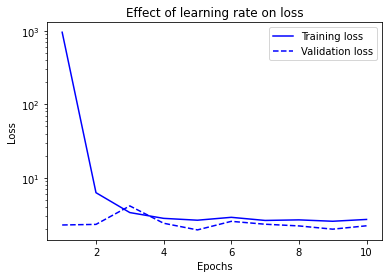

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
plt.plot(epochs, history.history["loss"], "b-",
         label="Training loss")
plt.plot(epochs, history.history["val_loss"], "b--",
         label="Validation loss")

plt.title("Effect of learning rate on loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()

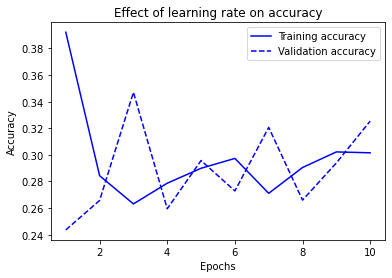

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
plt.plot(epochs, history.history["accuracy"], "b-",
         label="Training accuracy")
plt.plot(epochs, history.history["val_accuracy"], "b--",
         label="Validation accuracy")

plt.title("Effect of learning rate on accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

**The same model with a more appropriate learning rate**

In [21]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3598 - accuracy: 0.9112 - val_loss: 0.1647 - val_accuracy: 0.9541
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1396 - accuracy: 0.9632 - val_loss: 0.1341 - val_accuracy: 0.9672
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1160 - accuracy: 0.9719 - val_loss: 0.1865 - val_accuracy: 0.9657
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0973 - accuracy: 0.9780 - val_loss: 0.1653 - val_accuracy: 0.9713
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0900 - accuracy: 0.9811 - val_loss: 0.1966 - val_accuracy: 0.9728
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0811 - accuracy: 0.9836 - val_loss: 0.2272 - val_accuracy: 0.9686
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0654 - accuracy: 0.9870 - val_loss: 0.2198 - val_accuracy: 0.9743
Epoch 

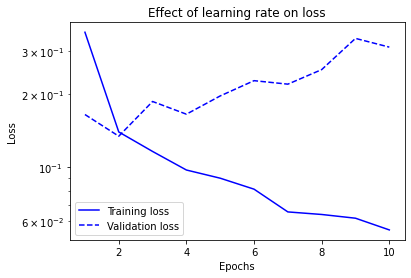

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
plt.plot(epochs, history.history["loss"], "b-",
         label="Training loss")
plt.plot(epochs, history.history["val_loss"], "b--",
         label="Validation loss")

plt.title("Effect of learning rate on loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()

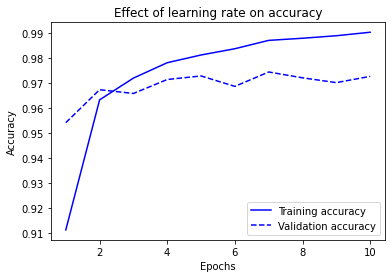

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
plt.plot(epochs, history.history["accuracy"], "b-",
         label="Training accuracy")
plt.plot(epochs, history.history["val_accuracy"], "b--",
         label="Validation accuracy")

plt.title("Effect of learning rate on accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

The model is now able to train.

If you find yourself in a similar situation, try:

- Lowering or increasing the **learning rate**. A learning rate that is too high may lead to updates that vastly overshoot a proper fit, like in the example above, and a learning rate that is too low may make training so slow that it appears to stall.
- Increasing the **batch size**. A batch with more samples will lead to gradients that are more informative and less noisy (lower variance).

In [28]:
# try a different batch size, what do you see?

### Leveraging better architecture priors

You have a model that fits, but for some reason your validation metrics aren’t improving at all. They remain no better than what a random classifier would achieve: your model trains, but doesn’t generalize. What’s going on?

This is perhaps the **worst machine learning situation** you can find yourself in. It indicates that something is **fundamentally wrong with your approach**, and it may not be easy to tell what. Here are some tips.

First, it may be that the input data you’re using simply doesn’t contain **sufficient information** to predict your targets: the problem as formulated is not solvable. This is what happened earlier when we tried to fit a MNIST model where the labels were shuffled: the model would train just fine, but validation accuracy would stay stuck at 10%, because it was plainly **impossible to generalize** with such a dataset.

It may also be that the kind of model you’re using is **not suited for the problem at hand**. For instance, in chapter 10, you’ll see an example of a timeseries prediction problem where a densely-connected architecture isn’t able to beat a trivial baseline, whereas a more appropriate recurrent architecture does manage to generalize well. Using a model that makes the **right assumptions** about the problem is essential to achieve generalization: you should leverage the right **architecture priors**.


### Increasing model capacity

If you manage to get to a model that fits, where validation metrics are going down, and that seems to achieve at least some level of generalization power, congratulations: **you’re almost there**. Next, you need to get your model to start overfitting.

**A simple logistic regression on MNIST**

Consider the following small model—a simple logistic regression—trained on MNIST pixels.

In [32]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=0)

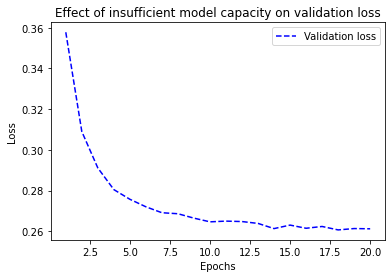

In [33]:
import matplotlib.pyplot as plt

val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")

plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Validation metrics seems to **stall, or to improve very slowly, instead of peaking and reversing course**. The validation loss goes to $0.26$ and just stays there. You can fit, but you **can’t clearly overfit**, even after many iterations over the training data. You’re likely to encounter similar curves often in your career.

Remember that it should **always be possible to overfit**. Much like the problem "the training loss doesn’t go down", this is an issue that can always be solved. If you can’t seem to be able to overfit, it’s likely a problem with the **representational power** of your model: you’re going to need a bigger model. One with more **capacity**, that is to say, able to store more information. You can increase representational power by **adding more layers, using bigger layers** (layers with more parameters), or using kinds of layers that are more appropriate for the problem at hand (better **architecture priors**).

In [36]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.3603 - accuracy: 0.8969 - val_loss: 0.1793 - val_accuracy: 0.9495
Epoch 2/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1610 - accuracy: 0.9514 - val_loss: 0.1489 - val_accuracy: 0.9554
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1149 - accuracy: 0.9660 - val_loss: 0.1117 - val_accuracy: 0.9688
Epoch 4/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0883 - accuracy: 0.9731 - val_loss: 0.1058 - val_accuracy: 0.9704
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0715 - accuracy: 0.9783 - val_loss: 0.0929 - val_accuracy: 0.9726
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0590 - accuracy: 0.9822 - val_loss: 0.0913 - val_accuracy: 0.9738
Epoch 7/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0498 - accuracy: 0.9846 - val_loss: 0.0937 - val_accuracy: 0.9746
Epoch 

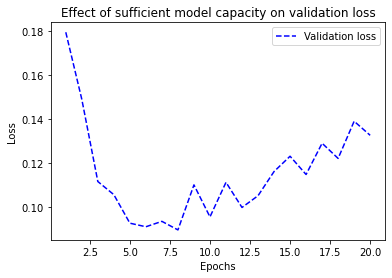

In [38]:
import matplotlib.pyplot as plt

val_loss = history_large_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")

plt.title("Effect of sufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Improving generalization

Once your model has shown to have some generalization power and to be able to overfit, it’s time to switch your focus towards **maximizing generalization**.

### Dataset curation

As such, it is essential that you make sure that you’re working with an appropriate dataset. Spending more effort and money on data collection almost always yields a much greater return on investment than spending the same on developing a better model.

- Make sure you have **enough data**. Remember that you need a **dense sampling of the input-cross-output space**. More data will yield a better model. Sometimes, problems that seem impossible at first become solvable with a larger dataset.
- **Minimize labeling errors**—visualize your inputs to check for anomalies, and proof-read your labels.
- Clean your data and deal with missing values (we cover this in the next chapter).
- If you have many features and you aren’t sure which ones are actually useful, do **feature selection**.

A particularly important way you can improve the generalization potential of your data is **feature engineering**. For most machine learning problems, feature engineering is a key ingredient for success. Let’s take a look.

### Feature engineering

Let’s look at an intuitive example. Suppose you’re trying to develop a model that can take as input an image of a clock and can output the time of day

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/clock_diagram.png)

That’s the essence of feature engineering: making a problem **easier by expressing it in a simpler way**. Make the latent manifold smoother, simpler, better-organized. It usually requires understanding the problem in depth.

Before deep learning, feature engineering used to be the most important part of the machine learning workflow, because **classical shallow algorithms didn’t have hypothesis spaces rich enough to learn useful features** by themselves. The way you presented the data to the algorithm was absolutely critical to its success. For instance, before convolutional neural networks became successful on the MNIST digit-classification problem, solutions were typically based on hardcoded features such as the number of loops in a digit image, the height of each digit in an image, a histogram of pixel values, and so on.

Fortunately, modern deep learning **removes the need for most feature engineering**, because neural networks are capable of **automatically extracting useful features** from raw data. Does this mean you don’t have to worry about feature engineering as long as you’re using deep neural networks? No, for two reasons:

- Good features still allow you to **solve problems more elegantly** while using fewer resources. For instance, it would be ridiculous to solve the problem of reading a clock face using a convolutional neural network.
- Good features let you solve a problem with **far less data**. The ability of deep-learning models to learn features on their own relies on having lots of training data available; if you have only a few samples, then the information value in their features becomes critical.

### Using early stopping

In deep learning, we always use models that are vastly **over-parameterized**: they have way more degrees of freedom than the minimum necessary to fit to the latent manifold of the data. This over-parameterization is not an issue, because you never fully fit a deep learning model. Such a fit wouldn’t generalize at all. You will always interrupt training long before you’ve reached the minimum possible training loss.

Finding the exact point during training where you’ve reached the most generalizable fit—the exact boundary between an underfit curve and an overfit curve—is one of the most effective things you can do to improve generalization.

In the examples from the previous chapter, we would start by training our models for longer than needed to figure out the number of epochs that yielded the best validation metrics, then we would re-train a new model for exactly that number of epochs. This is pretty standard. However, it requires you to do redundant work, which can sometimes be expensive. Naturally, you could just save your model at the end of each epoch, then once you’ve found the best epoch, reuse the closest saved model you have. In Keras, it’s typical to do this with an `EarlyStopping` callback, which will interrupt training as soon as validation metrics have stopped improving, while remembering the best known model state.


### Regularizing your model

Regularization techniques are a set of best practices that actively impede the model’s ability to fit perfectly to the training data, with the **goal of making the model perform better during validation**. This is called "regularizing" the model, because it tends to make the model **simpler, more "regular", its curve smoother, more "generic"** —thus less specific to the training set and better able to generalize by more closely approximating the latent manifold of the data.

Keep in mind that "regularizing" a model is a process that should always be guided by an accurate evaluation procedure. You will only achieve generalization if you can measure it.


#### Reducing the network's size

You’ve already learned that a model that is too small will not overfit. The simplest way to **mitigate overfitting is to reduce the size of the model** (the number of learnable parameters in the model, determined by the number of layers and the number of units per layer). If the model has **limited memorization resources**, it won’t be able to simply memorize its training data; thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets—precisely the type of representations we’re interested in. At the same time, keep in mind that you should use models that have enough parameters that they don’t underfit: your model shouldn’t be starved for memorization resources. There is a compromise to be found between too much capacity and not enough capacity.

Unfortunately, **there is no magical formula to determine the right number of layers or the right size for each layer**. You must evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the correct model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and parameters, and increase the size of the layers or add new layers until you see diminishing returns with regard to validation loss.


**Original model**

In [43]:
import numpy as np

from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 18ms/step - loss: 0.5207 - accuracy: 0.7835 - val_loss: 0.3897 - val_accuracy: 0.8725
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3143 - accuracy: 0.9011 - val_loss: 0.3080 - val_accuracy: 0.8879
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2297 - accuracy: 0.9274 - val_loss: 0.2950 - val_accuracy: 0.8807
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1806 - accuracy: 0.9421 - val_loss: 0.2733 - val_accuracy: 0.8936
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1480 - accuracy: 0.9532 - val_loss: 0.3035 - val_accuracy: 0.8825
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1206 - accuracy: 0.9628 - val_loss: 0.3162 - val_accuracy: 0.8803
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1008 - accuracy: 0.9705 - val_loss: 0.3210 - val_accuracy: 0.8826
Epoch 8/20
30/30 [=

**Version of the model with lower capacity**

In [44]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 1s 16ms/step - loss: 0.6275 - accuracy: 0.6468 - val_loss: 0.5727 - val_accuracy: 0.7355
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.5274 - accuracy: 0.7985 - val_loss: 0.5330 - val_accuracy: 0.7376
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.4700 - accuracy: 0.8651 - val_loss: 0.4921 - val_accuracy: 0.8035
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.4068 - accuracy: 0.9102 - val_loss: 0.4227 - val_accuracy: 0.8742
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3398 - accuracy: 0.9303 - val_loss: 0.3827 - val_accuracy: 0.8743
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2775 - accuracy: 0.9413 - val_loss: 0.3402 - val_accuracy: 0.8845
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2274 - accuracy: 0.9504 - val_loss: 0.3093 - val_accuracy: 0.8888
Epoch 8/20
30/30 [

**Version of the model with higher capacity**

In [49]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 3s 78ms/step - loss: 0.5584 - accuracy: 0.7409 - val_loss: 0.4829 - val_accuracy: 0.7798
Epoch 2/20
30/30 [==============================] - 2s 69ms/step - loss: 0.2472 - accuracy: 0.9023 - val_loss: 0.4801 - val_accuracy: 0.8127
Epoch 3/20
30/30 [==============================] - 2s 72ms/step - loss: 0.1721 - accuracy: 0.9330 - val_loss: 0.3044 - val_accuracy: 0.8844
Epoch 4/20
30/30 [==============================] - 2s 69ms/step - loss: 0.0775 - accuracy: 0.9733 - val_loss: 0.3638 - val_accuracy: 0.8902
Epoch 5/20
30/30 [==============================] - 2s 69ms/step - loss: 0.0544 - accuracy: 0.9820 - val_loss: 0.4051 - val_accuracy: 0.8891
Epoch 6/20
30/30 [==============================] - 2s 68ms/step - loss: 0.0627 - accuracy: 0.9855 - val_loss: 0.3449 - val_accuracy: 0.8803
Epoch 7/20
30/30 [==============================] - 2s 68ms/step - loss: 0.0038 - accuracy: 0.9999 - val_loss: 0.5430 - val_accuracy: 0.8860
Epoch 8/20
30

Text(0.5, 1.0, 'Impact of model size on validation accuracy')

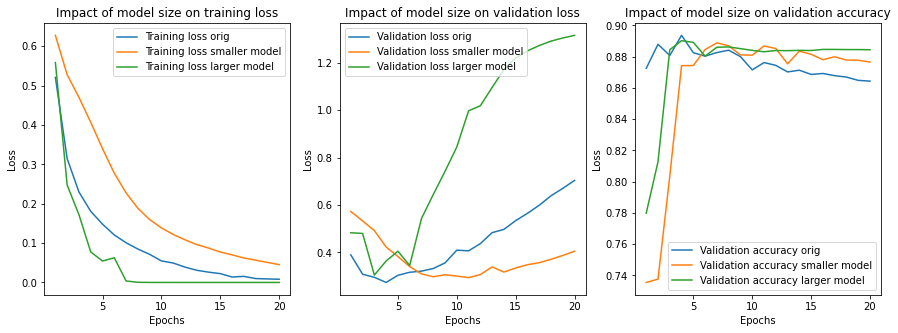

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15,5))

epochs = range(1, 21)

ax[0].plot(epochs, history_original.history["loss"], label="Training loss orig")
ax[0].plot(epochs, history_smaller_model.history["loss"], label="Training loss smaller model")
ax[0].plot(epochs, history_larger_model.history["loss"], label="Training loss larger model")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Impact of model size on training loss")

ax[1].plot(epochs, history_original.history["val_loss"], label="Validation loss orig")
ax[1].plot(epochs, history_smaller_model.history["val_loss"], label="Validation loss smaller model")
ax[1].plot(epochs, history_larger_model.history["val_loss"], label="Validation loss larger model")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Impact of model size on validation loss")

ax[2].plot(epochs, history_original.history["val_accuracy"], label="Validation accuracy orig")
ax[2].plot(epochs, history_smaller_model.history["val_accuracy"], label="Validation accuracy smaller model")
ax[2].plot(epochs, history_larger_model.history["val_accuracy"], label="Validation accuracy larger model")
ax[2].legend()
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")
ax[2].set_title("Impact of model size on validation accuracy")

#### Adding weight regularization

You may be familiar with the principle of **Occam’s razor**: given two explanations for something, the explanation most likely to be correct is the simplest one—the one that makes fewer assumptions. This idea also applies to the models learned by neural networks: given some training data and a network architecture, multiple sets of weight values (multiple models) could explain the data. **Simpler models are less likely to overfit than complex ones**.

A simple model in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters, as you saw in the previous section). Thus a common way to mitigate overfitting is to put **constraints on the complexity of a model** by forcing its weights to take only small values, which makes the distribution of weight values more regular. This is called **weight regularization**, and it’s done by adding to the loss function of the model a cost associated with having large weights. This cost comes in two flavors:

- **L1 regularization** — The cost added is proportional to the **absolute value** of the weight coefficients (the L1 norm of the weights).
- **L2 regularization** — The cost added is proportional to the **square of the value** of the weight coefficients (the L2 norm of the weights). L2 regularization is also called **weight decay** in the context of neural networks. Don’t let the different name confuse you: weight decay is mathematically the same as L2 regularization.

In Keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let’s add L2 weight regularization to the movie-review classification model.


**Adding L2 weight regularization to the model**

In [63]:
from tensorflow.keras import regularizers, layers
from tensorflow import keras

model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6010 - accuracy: 0.7915 - val_loss: 0.4724 - val_accuracy: 0.8731
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.4113 - accuracy: 0.8939 - val_loss: 0.4086 - val_accuracy: 0.8759
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3460 - accuracy: 0.9126 - val_loss: 0.3743 - val_accuracy: 0.8853
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3110 - accuracy: 0.9213 - val_loss: 0.3625 - val_accuracy: 0.8906
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2906 - accuracy: 0.9305 - val_loss: 0.3653 - val_accuracy: 0.8852
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2774 - accuracy: 0.9323 - val_loss: 0.3659 - val_accuracy: 0.8859
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2642 - accuracy: 0.9390 - val_loss: 0.3753 - val_accuracy: 0.8804
Epoch 8/20
30/30 [

`l2(0.002)` means every coefficient in the weight matrix of the layer will add `0.002 * weight_coefficient_value ** 2` to the total loss of the model. Note that because this penalty is only added at training time, the loss for this model will be much higher at training than at test time.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/original_model_vs_l2_regularized_model_imdb.png)

**Different weight regularizers available in Keras**

Note that weight regularization is more typically used for **smaller deep learning models**. Large deep learning models tend to be so over-parameterized that imposing constraints on weight values hasn’t much impact on model capacity and generalization. In these cases, a different regularization technique is preferred: dropout.

In [0]:
from keras import regularizers

regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)

#### Adding dropout

**Dropout** is one of the most effective and most commonly used regularization techniques for neural networks, developed by Geoff Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly dropping out (setting to zero) a number of output features of the layer during training. Let’s say a given layer would normally return a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training. After applying dropout, this vector will have a few zero entries distributed at random: for example, `[0, 0.5, 1.3, 0, 1.1]`. The **dropout rate** is the fraction of the features that are zeroed out; it’s usually set between $0.2$ and $0.5$. At test time, no units are dropped out; instead, the layer’s output values are scaled down by a factor equal to the dropout rate, to balance for the fact that more units are active than at training time.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/dropout.png)

**Adding dropout to the IMDB model**

In Keras, you can introduce dropout in a model via the `Dropout` layer, which is applied to the output of the layer right before it. Let’s add two Dropout layers in the IMDB model to see how well they do at reducing overfitting.

In [64]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),  # new
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),  # new
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.6182 - accuracy: 0.6493 - val_loss: 0.4793 - val_accuracy: 0.8506
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.4834 - accuracy: 0.7799 - val_loss: 0.3791 - val_accuracy: 0.8745
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3970 - accuracy: 0.8339 - val_loss: 0.3161 - val_accuracy: 0.8853
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.3423 - accuracy: 0.8621 - val_loss: 0.3065 - val_accuracy: 0.8771
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.3001 - accuracy: 0.8842 - val_loss: 0.2978 - val_accuracy: 0.8770
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2602 - accuracy: 0.9031 - val_loss: 0.2831 - val_accuracy: 0.8848
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2366 - accuracy: 0.9131 - val_loss: 0.2772 - val_accuracy: 0.8924
Epoch 8/20
30/3

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/original_model_vs_dropout_regularized_model_imdb.png)

## Chapter summary

To recap, these are the most common ways to **maximize generalization and prevent overfitting** in neural networks:

- Get more training data, or better training data.
- Develop better features.
- Reduce the capacity of the model (smaller, architecture).
- Add weight regularization (for smaller models).
- Add dropout.

- The purpose of a machine learning model is to generalize: to perform accurately on never-seen-before inputs. It’s harder than it seems.
- A deep neural network achieves generalization by learning a parametric model that can successfully interpolate between training samples—such a model can be said to have learned the "latent manifold" of the training data. This is why deep learning models can only make sense of inputs that are very close to what they’ve seen during training.
- The fundamental problem in machine learning is the tension between optimization and generalization: to attain generalization, you must first achieve a good fit to the training data, but improving your model’s fit to the training data will inevitably start hurting generalization after a while. Every single deep learning best practice deals with managing this tension.
- The ability of deep learning models to generalize comes from the fact that they manage to learn to approximate the latent manifold of their data, and can thus make sense of new inputs via interpolation.
- It’s essential to be able to accurately evaluate the generalization power of your model while you’re developing it. You have at your disposable an array of evaluation methods, from simple hold-out validation, to K-fold cross-validation and iterated K-fold cross-validation with shuffling. Remember to always keep a completely separate test set for final model evaluation, since information leaks from your validation data to your model may have occurred.
- When you start working on a model, your goal is first to achieve a model that has some generalization power and that can overfit. Best practices to do this include **tuning your learning rate and batch size, leveraging better architecture priors, increasing model capacity, or simply training longer**.
- As your model starts overfitting, your goal switches to improving generalization through model regularization. You can reduce your model’s capacity, add dropout or weight regularization, and use early stopping. And naturally, a larger or better dataset is always the number one way to help a model generalize.